In [21]:
import matplotlib.pyplot as plt
from astropy.io import fits
import torch
import numpy as np
from aion.modalities import LegacySurveyImage
import h5py
from tqdm import tqdm
import umap
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)

In [2]:
test_file = h5py.File('/pscratch/sd/a/ashodkh/rubin_dp1/semi_supervised_test_i_snr_20.hdf5', 'r')


In [8]:
from aion.codecs import CodecManager

# Instantiate the manager
codec_manager = CodecManager(device="cuda")

# Apply a codec on our prepared image
# This will automatically download the necessary codec
tokens = codec_manager.encode(image)

from aion.model import AION

# Disable gradients for this notebook
torch.set_grad_enabled(False)

# Importing model
model = AION.from_pretrained("polymathic-ai/aion-base").to("cuda").eval()


In [6]:
ims = torch.tensor(test_file['images'][:,1:5,:,:].astype('float32')).to("cuda")
images = LegacySurveyImage(flux=ims, bands=["DES-G", "DES-R", "DES-I", "DES-Z"])

In [14]:
# Instantiate the manager
codec_manager = CodecManager(device="cuda")
batch_size = 32
n = ims.shape[0]
im_embeddings = []
for i in tqdm(range(0, n, batch_size)):
    images = LegacySurveyImage(flux=ims[i : min(n,i+batch_size)], bands=["DES-G", "DES-R", "DES-I", "DES-Z"])
    im_embeddings.append(
        model.encode(codec_manager.encode(images), num_encoder_tokens=600).mean(axis=1)
    )

100%|██████████| 89/89 [00:32<00:00,  2.74it/s]


In [15]:
im_embeddings = torch.cat(im_embeddings, dim=0).cpu().numpy()
reducer = umap.UMAP()
embedding = reducer.fit_transform(im_embeddings)
embedding.shape


(2830, 2)

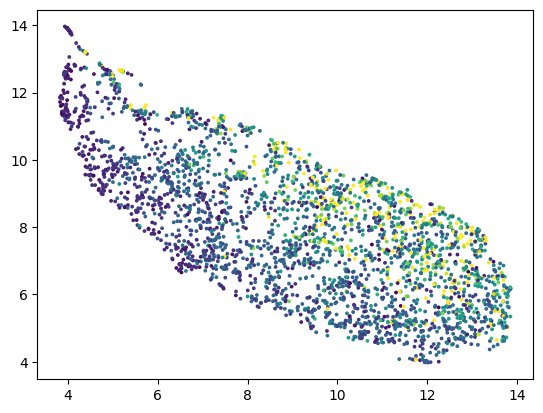

In [18]:
fig, ax = plt.subplots()

ax.scatter(embedding[:,0], embedding[:,1], s=3, c=test_file['redshifts'][:], vmin=0, vmax=2)

In [62]:
from astropy.visualization import make_lupton_rgb, make_rgb, ManualInterval, LogStretch

def make_rgb_image(image):
    pctl = 99.9
    maximum = 0.
    for img in [image[2,:,:],image[1,:,:],image[0,:,:]]:
        val = np.percentile(img,pctl)
        if val > maximum:
            maximum = val
    rgb_image = make_rgb(image[3,:,:],image[2,:,:],image[0,:,:],
                         interval=ManualInterval(vmin=0, vmax=maximum),
                         stretch=LogStretch(a=30))
    return rgb_image

In [63]:
test_file['images'][random_index,1:5,:,:].shape

(4, 108, 108)

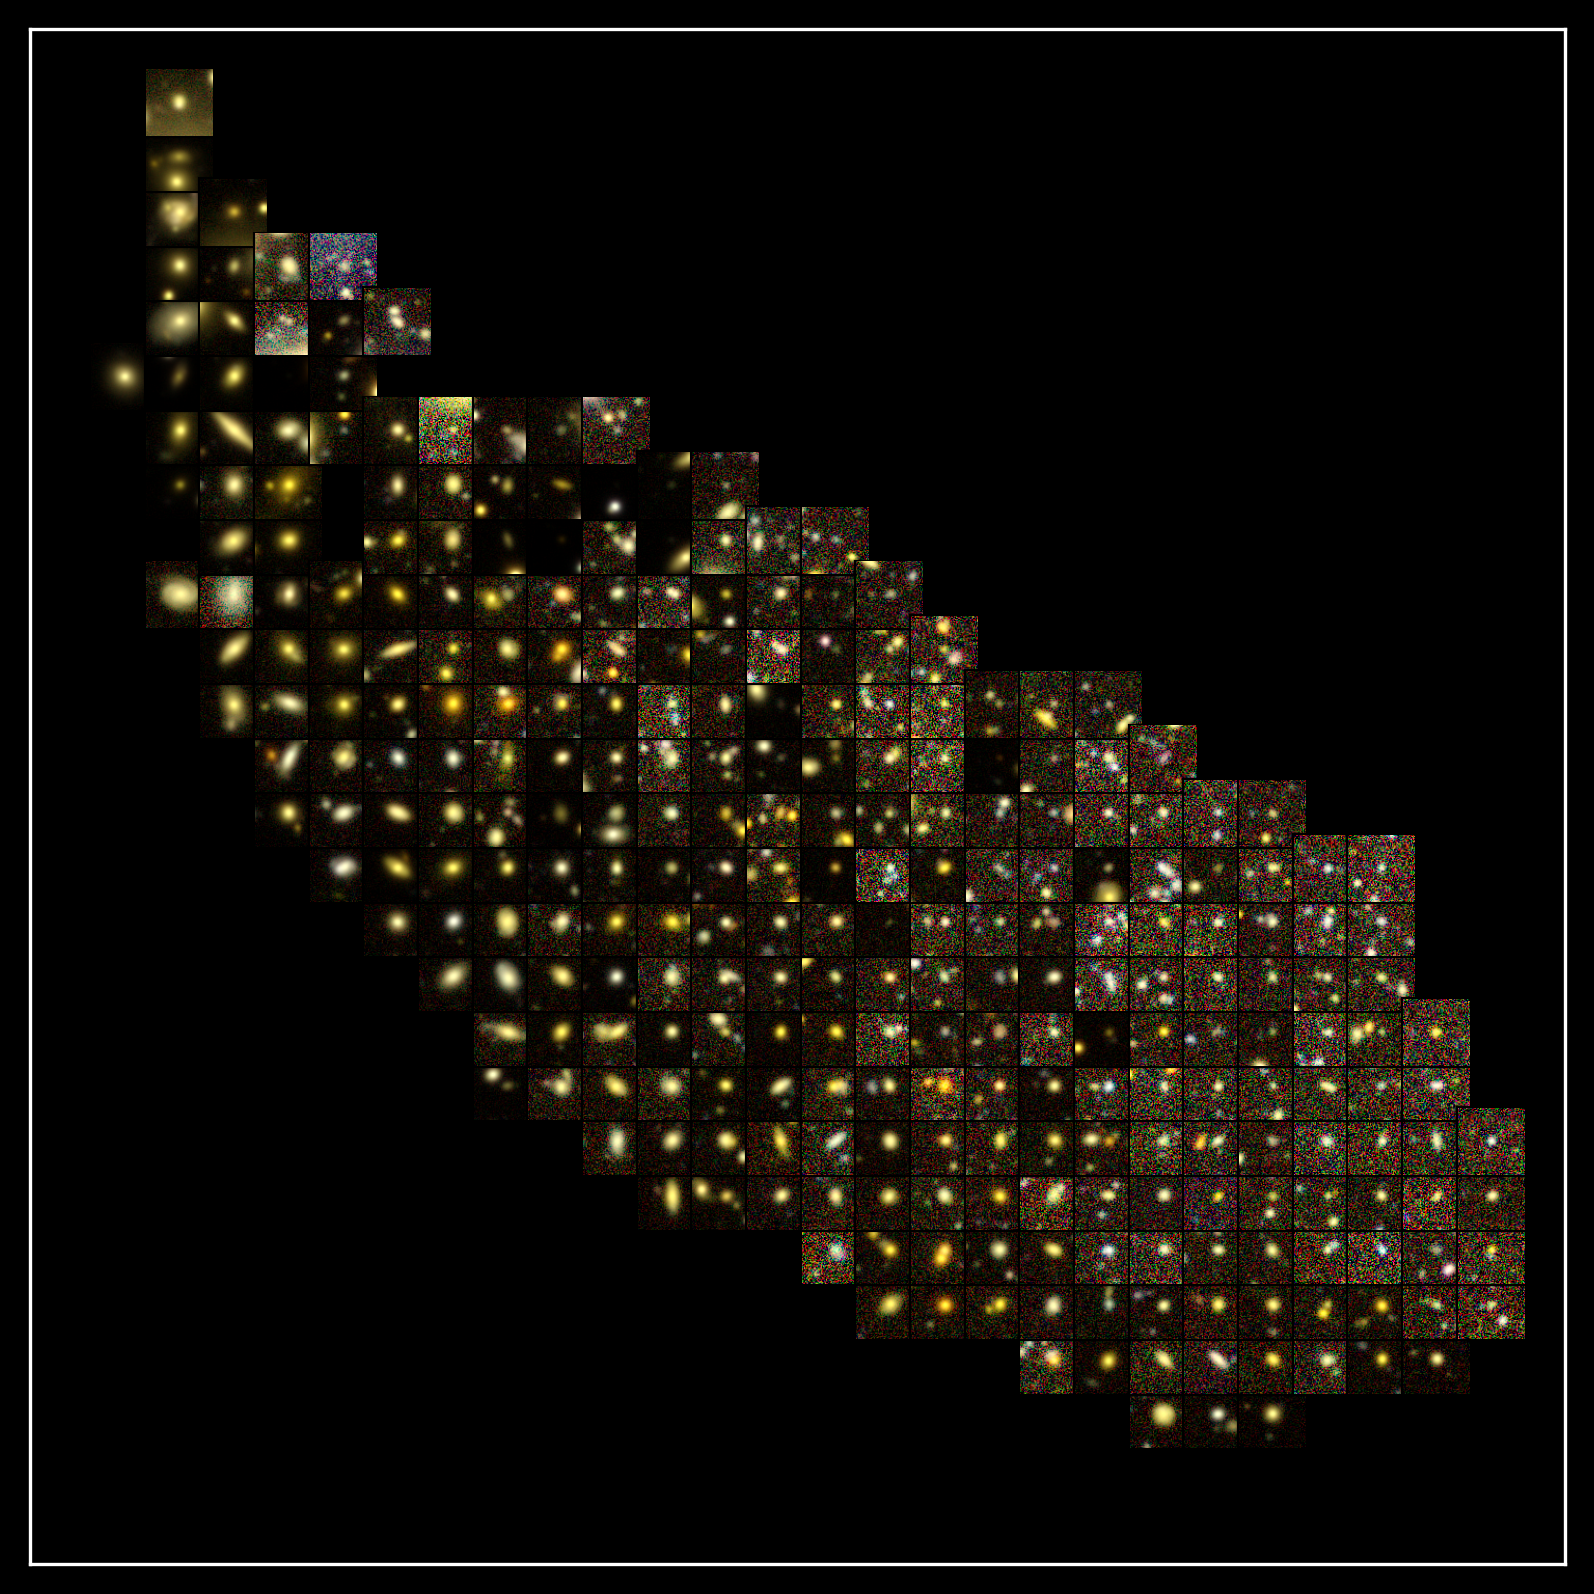

In [73]:
plt.style.use('dark_background')

fig, ax = plt.subplots(layout='constrained', figsize=(8.2, 5.2), dpi=300)

n_bins = 30
# x_bins = np.linspace(-6, 18, n_bins)
# y_bins = np.linspace(-2, 13, n_bins)
x_bins = np.linspace(3, 15, n_bins)
y_bins = np.linspace(3, 15, n_bins)

for i in range(len(x_bins)-1):
    for j in range(len(y_bins)-1):
        bin_mask = (embedding[:,0]>x_bins[i]) * (embedding[:,0]<=x_bins[i+1]) * (embedding[:,1]>y_bins[j]) * (embedding[:,1]<=y_bins[j+1]) 
        #print(np.sum(bin_mask))
        #ax.scatter(embedding[bin_mask,0], embedding[bin_mask,1], c=redshifts[bin_mask], s=5, vmin=0, vmax=4, cmap='inferno')
        bin_inds = np.where(bin_mask)[0]
        if len(bin_inds) > 0:
            random_index = np.random.choice(bin_inds, size=1, replace=False).squeeze()
            bin_center = (x_bins[i] + x_bins[i+1])/2, (y_bins[j] + y_bins[j+1])/2
            rgb_image = make_rgb_image(test_file['images'][random_index,1:5,54-32:54+32,54-32:54+32])
            #ax.scatter(bin_center[0], bin_center[1], s=5, c=np.average(redshifts[bin_inds]), vmin=0, vmax=4, cmap='inferno')
            im = OffsetImage(rgb_image, zoom=0.25)
            im.image.axes = ax
            ab = AnnotationBbox(im, bin_center,
                                xycoords='data',
                                boxcoords="offset points",
                                pad=0,)
            ax.add_artist(ab)

ax.set_xlim(3, 15)
ax.set_ylim(3, 15)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel('UMAP axis 1', fontsize=40)
# ax.set_ylabel('UMAP axis 2', fontsize=40)
ax.set_aspect('equal', adjustable='box')


